<img src="../../notebook_banner.png" width="1024" style="float:center">
<div style="margin-top:10px; display:flex; align-items:center;">
    <div style="float:left; margin-right:10px;vertical-align:middle">
        <a href="https://www.linkedin.com/in/bruno-angles/" targer="_blank">
            <img src="../../lkin-logo.png"/>
        </a>
    </div>
    <div> 
        Bruno Anglés (17/12/2022)
    </div>
 </div>

# Análisis predictivo del precio de la vivienda

## Importación del librerías

In [1]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

params = {'axes.titlesize':'10'}
plt.rcParams.update(params)

import seaborn as sns
plt_colors = list(sns.color_palette().as_hex())

def plt_color(i):
    return plt_colors[i % len(plt_colors)]


## Importación de datos

In [2]:
target = "price"

In [3]:
housedata = pd.read_csv("data.csv", parse_dates=["date"])

In [4]:
housedata.shape

(4600, 18)

In [5]:
housedata.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


## Limpieza de datos

### Detección y tratamiento de valores nulos

In [6]:
housedata.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

Aparentemente el dataset no tiene valores nulos. Tenemos que esperar a un análisis en profundidad de las distintas columnas para detectar valores incorrectos

### Detección de duplicados

In [7]:
dup = len(housedata) - len(housedata.drop_duplicates())
print("Duplicados encontrados:", dup)

Duplicados encontrados: 0


## EDA - Análisis exploratorio del dataset

### Descripción y tratamiento de las columnas del dataset

In [8]:
# Columnas del dataframe 
housedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4600 non-null   datetime64[ns]
 1   price          4600 non-null   float64       
 2   bedrooms       4600 non-null   float64       
 3   bathrooms      4600 non-null   float64       
 4   sqft_living    4600 non-null   int64         
 5   sqft_lot       4600 non-null   int64         
 6   floors         4600 non-null   float64       
 7   waterfront     4600 non-null   int64         
 8   view           4600 non-null   int64         
 9   condition      4600 non-null   int64         
 10  sqft_above     4600 non-null   int64         
 11  sqft_basement  4600 non-null   int64         
 12  yr_built       4600 non-null   int64         
 13  yr_renovated   4600 non-null   int64         
 14  street         4600 non-null   object        
 15  city           4600 n

In [9]:
numeric_columns = [col for col in housedata.columns if housedata[col].dtype != "object" and col != target]
print("Variables numéricas:\n", numeric_columns)

Variables numéricas:
 ['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


#### Columna `date`

En [Kaggle](https://www.kaggle.com/datasets/shree1992/housedata?select=data.csv) no encontramos una descripción precisa de su significado. Para interpretar las variables hemos recurrido al [siguiente notebook](https://www.kaggle.com/code/hnnhytc/data-analysis-with-python). Por lo tanto consideramos que `date` es al fecha d venta de la vivienda.

¿Es relevante esta variable para nuestro modelo de regresión?

Date min: 2014-05-02 00:00:00
Date max: 2014-07-10 00:00:00


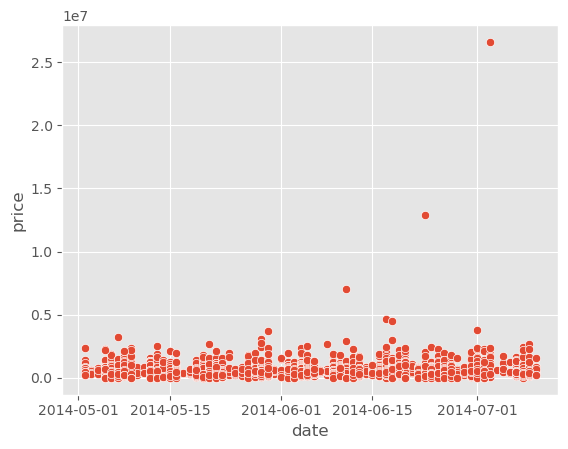

In [10]:
print("Date min:", housedata.date.min())
print("Date max:", housedata.date.max())
sns.scatterplot(data=housedata, x="date", y="price")
plt.show()

Según vemos, los datos fueron obtenidos durante los meses de mayo, juno y julio de 2014. Consideramos que son datos insuficientes para observar una estacionalidad que podamos generalizar, por lo que decidimos eliminar esta columna del dataframe.

<div class="alert alert-block alert-warning"> 
    Deberemos eliminar la variable <code>date</code> durante la fase de pre-procesado
</div>

In [11]:
numeric_columns = [c for c in numeric_columns if c != "date"]

#### Datos numéricos

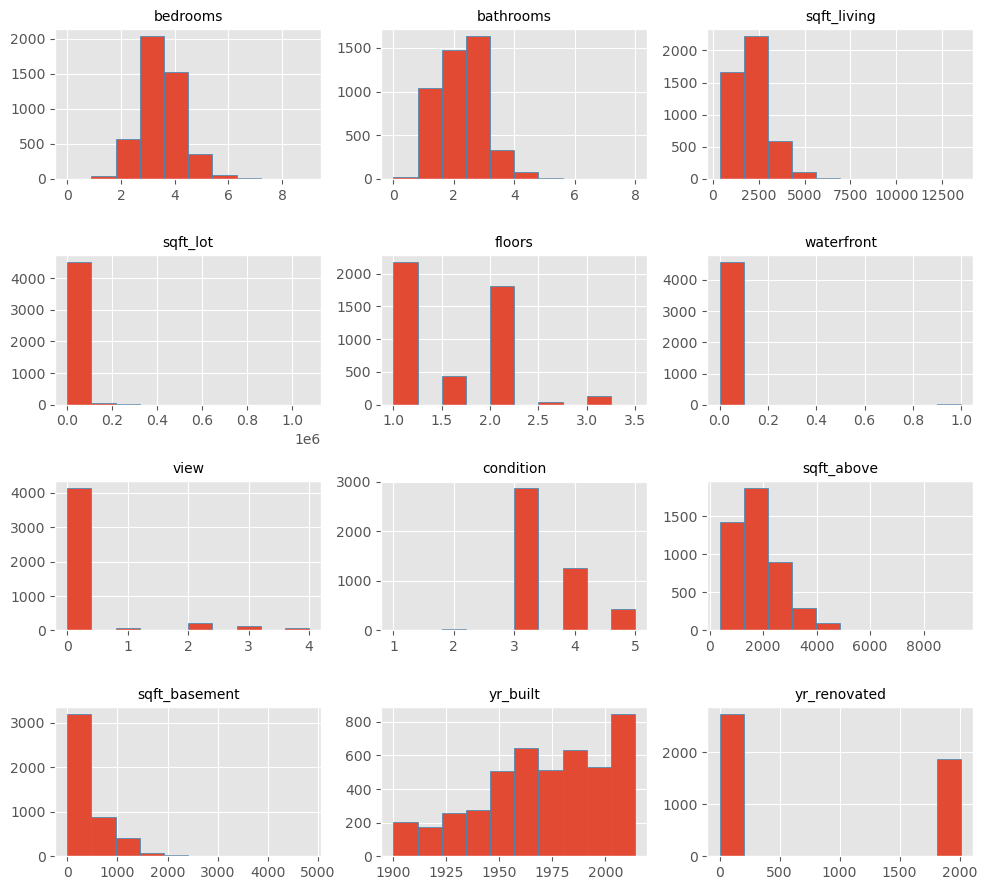

In [12]:
housedata[numeric_columns].hist(figsize=(10,9), ec=plt_colors[1])

plt.tight_layout()

In [13]:
housedata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


- `price`: es nuestra **variable objetivo**, el precio de venta la vivienda.
- `bedrooms`: número de habitaciones
- `bathrooms`: número de baños
- `sqft_living`: superficie habitable
- `sqft_lot`: superficie de la parcela
- `floors`: número de plantas de la vivienda
- `sqft_above`: superficie de la vivienda sin tener en cuenta el sótano
- `sqft_basement`: superficie del sótano
- `yr_built`: Año de construcción
- `yr_renovated`: Año en el que la casa fué renovada
- `view`: cantidad de veces que ha sido vista la vivienda

*¿Son estas variables categóricas?*

Ciertas columnas que aparecen en el DataFrame como numéricas puede que sea mejor tratarlas como categóricas.

- `condition`: condición general de la vivienda
- `waterfront`: si tiene vistas al agua

A la vista de los histogramas lo parecen. No obstante ya vienen codificadas numéricamente de un modo adecuado, por lo que se van a dejar tal como están.

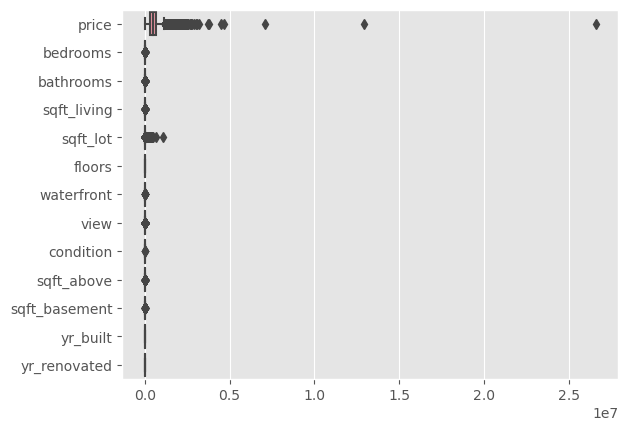

In [14]:
# Comprobamos si hay valores anómalos en las variables numéricas
sns.boxplot(data=housedata, orient="h")
plt.show()


<div class="alert alert-block alert-warning"> 
    <p><strong>Valores anómalos</strong></p>
    <p>Vemos que hay presencia de valores anómalos tanto para la variable objetivo como para <code>sqft_lot</code>. ¿Tienen relación ambas situaciones?. Vamos a analizar estas variables juntas cuando lleguemos a la variable objetivo.
        </p>
</div>

#### Año de construcción y año de renovación

Año de construcción (min) 1900
Año de construcción (max) 2014


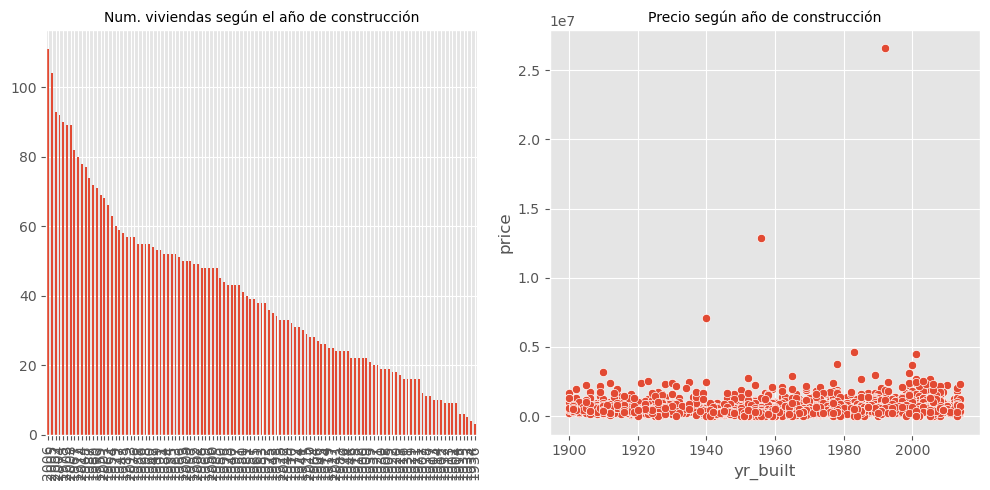

In [15]:
# Año de construccion
print("Año de construcción (min)", housedata.yr_built.min())
print("Año de construcción (max)", housedata.yr_built.max())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].title.set_text("Num. viviendas según el año de construcción")
housedata.yr_built.value_counts().plot(kind="bar", ax=axes[0])

axes[1].title.set_text("Precio según año de construcción")
sns.scatterplot(data=housedata, x="yr_built", y="price", ax=axes[1])
plt.tight_layout()

Consideramos que para el modelo de regresión generalizaría mejor si en vez de considerar el año de consgtrucción tuviéramos en cuenta la antiguedad de la vivienda. De este modo el modelo podría aplicar a viviendas construidas después del 2014.

<div class="alert alert-block alert-warning"> 
    Deberemos sintetizar una nueva variable que llamaremos `yr_old` como la diferencia entre el año de venta `date` y el año de construcción `yr_built`
</div>

Año de renovación (min) 0
Año de renovación (max) 2014


/var/folders/jy/88_thsfj3xx4wvtlz4y08p6m7s11b_/T/ipykernel_82579/172292350.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux["yr_diff"] = aux.yr_renovated - aux.yr_built


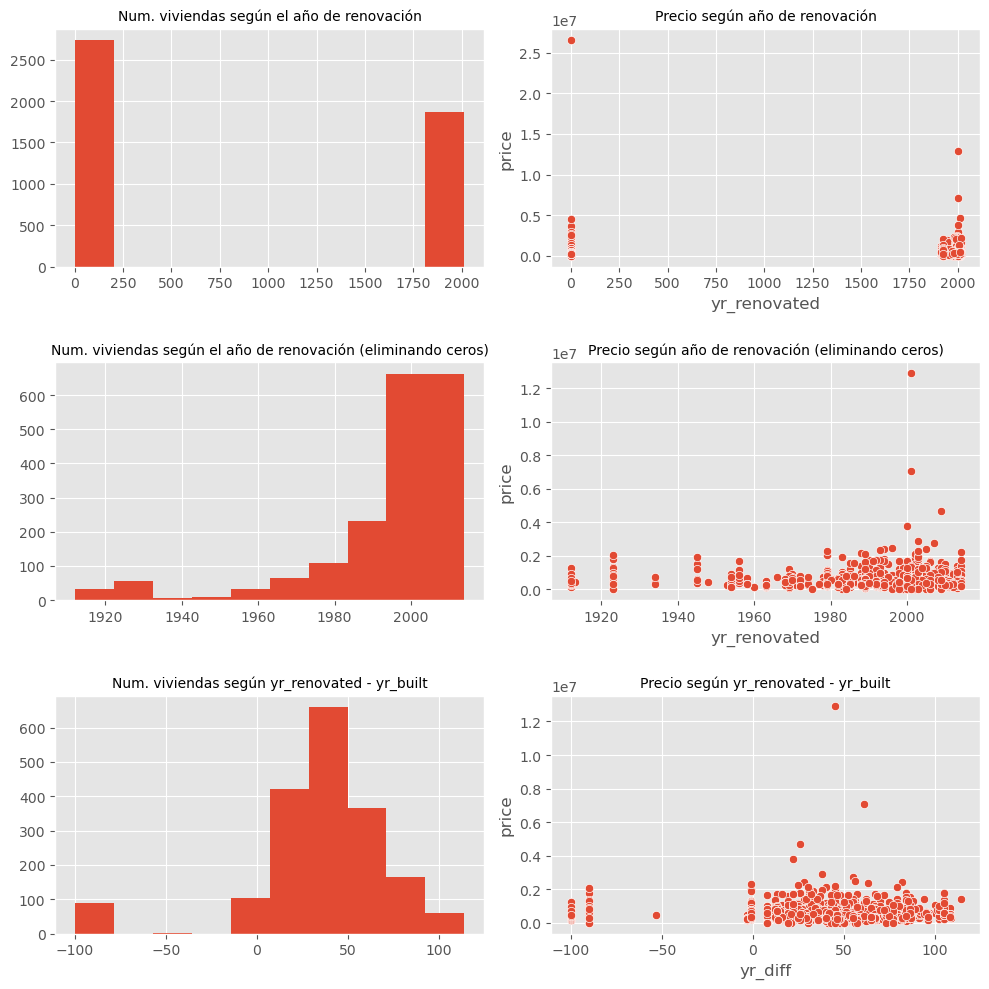

In [16]:
## Año de renovación

print("Año de renovación (min)", housedata.yr_renovated.min())
print("Año de renovación (max)", housedata.yr_renovated.max())

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

axes[0][0].title.set_text("Num. viviendas según el año de renovación")
housedata.yr_renovated.hist(ax=axes[0][0])

axes[0][1].title.set_text("Precio según año de renovación")
sns.scatterplot(data=housedata, x="yr_renovated", y="price", ax=axes[0][1])

aux = housedata[housedata.yr_renovated > 0]

axes[1][0].title.set_text("Num. viviendas según el año de renovación (eliminando ceros)")
aux.yr_renovated.hist(ax=axes[1][0])

axes[1][1].title.set_text("Precio según año de renovación (eliminando ceros)")
sns.scatterplot(data=aux, x="yr_renovated", y="price", ax=axes[1][1])

aux["yr_diff"] = aux.yr_renovated - aux.yr_built

axes[2][0].title.set_text("Num. viviendas según yr_renovated - yr_built")
aux.yr_diff.hist(ax=axes[2][0])

axes[2][1].title.set_text("Precio según yr_renovated - yr_built")
sns.scatterplot(data=aux, x="yr_diff", y="price", ax=axes[2][1])

plt.tight_layout()

In [17]:
# Casos en los que el año de renovación es anterior al año de construcción

renovated_prior_built = aux[aux.yr_renovated < aux.yr_built]
print(renovated_prior_built.shape)
print(len(renovated_prior_built) / len(housedata), "%")
renovated_prior_built.head()

(195, 19)
0.042391304347826085 %


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,yr_diff
31,2014-05-02,499950.0,4.0,2.50,2860,3345,2.0,0,0,3,2190,670,2004,2003,20120 137th Ave NE,Woodinville,WA 98072,USA,-1
60,2014-05-02,555000.0,4.0,2.50,3310,6500,2.0,0,0,3,3310,0,2012,1912,35229 SE Terrace St,Snoqualmie,WA 98065,USA,-100
61,2014-05-02,459990.0,3.0,2.50,2680,5539,2.0,0,0,3,2680,0,2013,1923,13800 453rd Ave SE,North Bend,WA 98045,USA,-90
64,2014-05-03,625000.0,4.0,2.75,2920,6605,2.0,0,0,3,2920,0,2012,1912,5608 NE 5th Cir,Renton,WA 98059,USA,-100
68,2014-05-04,775000.0,2.0,2.50,2680,7392,1.0,0,0,3,2680,0,2004,2003,13134 234th Ct NE,Redmond,WA 98053,USA,-1


Respecto a la variable `yr_renovated` vemos varios problemas:

- hay un gran número de casos con valor `0`, lo cuál significa estas viviendas no han sido renovadas. Esto nos va a dar problemas en nuestro modelo de regresión
- hay casos en los que el año de renovación de la vivienda es anterior al año de construcción, estos casos represnetan el 4% del total

<div class="alert alert-block alert-warning"> 
    <p>Hay que tratar la variable <code>yr_renovated</code> para solucionar los problemas de datos. Se propone hacer lo siguiente durante el pre-procesado. Además esta columna debería reflejar la diferencia en años igual que hemos hecho con el año de construcción.</p>
    <p>La forma más rápida de tratar esto es sustituir esta variable usando el siguiente algoritmo
    <ol>
        <li>Si la variable es menor a <code>yr_built</code> sustituirla por <code>yr_old</code>. De este modo eliminamos los casos en los que la fecha de renovación es cero o menor a la de construcción.</li>
        <li>En caso contrario, restar <code>date - yr_renovated</code></li>
    </ol>
    </p>

</div>

### Dependencia lineal entre `sqft_living`, `sqft_above`  y `sqft_basement`

Parece que entre estas variables hay la siguiente dependencia lineal

$$
sqft\_living = sqft\_above + sqft\_basement
$$

Vamos a confirmar si es así en todos los casos

In [18]:
print("Dependencia lineal entre sqft_living, sqft_above y sqft_basement")
(
    pd.DataFrame(
        housedata.sqft_living == (housedata.sqft_above + housedata.sqft_basement)
        , columns=["ldep"])
    .reset_index()
    .groupby("ldep")
    .count()
)

Dependencia lineal entre sqft_living, sqft_above y sqft_basement


,index
ldep,
True,4600


<div class="alert alert-block alert-warning"> 
    En preprocesado eliminaremos la variable <code>sqft_living</code>  por ser una combinación de las otras dos
</div>

In [19]:
numeric_columns = [c for c in numeric_columns if c != "sqft_living"]

#### Datos categóricos

In [20]:
categorical_columns = [col for col in housedata.columns if housedata[col].dtype == "object"]
print("Variables categóricas:", categorical_columns)

Variables categóricas: ['street', 'city', 'statezip', 'country']


In [21]:
# Variables categóricas
housedata.describe(include=["object","category"],).transpose()

,count,unique,top,freq
street,4600,4525,2520 Mulberry Walk NE,4
city,4600,44,Seattle,1573
statezip,4600,77,WA 98103,148
country,4600,1,USA,4600


- `street`: nombre de la calle, esta columna parece poco útil, ya que el modelo sólo nos sería de utilidad para predecir el precio de venta de una vivienda en una de esas calles
- `city`: ciudad
- `statezip`: código postal
- `country`: país, esa es poco relevante ya que en todos los registros es igual

<div class="alert alert-block alert-warning"> 
    En preprocesado eliminaremos las variables categóricas <code>street</code> y <code>country</code>
</div>

In [22]:
categorical_columns = [col for col in categorical_columns if col not in ("street", "country")]
categorical_columns

['city', 'statezip']

**¿Són útiles el resto de variables categóricas?**

In [23]:
total_us_cities = 331
dataset_cities = len(housedata.city.unique())
print("El procentaje de ciudades representado en el dataset es de:"
      f" {dataset_cities / total_us_cities * 100:.2f}%")

total_us_zipcodes = 41683
dataset_zipcodes = len(housedata.statezip.unique())
print("El procentaje de códigos postales representados en el dataset es de:"
      f" {dataset_zipcodes / total_us_zipcodes * 100:.2f}%")

El procentaje de ciudades representado en el dataset es de: 13.29%
El procentaje de códigos postales representados en el dataset es de: 0.18%


Usar las variables `statezip` y `city` limita el uso del modelo a las ciudades y códigos postales incluídos en el entrenamiento. Además estas variables son redundantes ya que un código postal sólo puede pertenecer a una única ciudad

<div class="alert alert-block alert-info"> 
    <p>
    <b><a id="city_and_statezip">[1]</a></b> Plantearemos varias hipótesis de entrenamisnto
    <ul>
        <li>Una en la que excluyamos estas dos variables</li>
        <li>Otra en el que incluyamos <code>statezip</code> o <code>city</code>, entrenando dos modelos diferentes</li>
    </ul>
    </p>
    <p>
        La estrategia será ver si conseguimos más precisión usando la información sobre el código postal o la ciudad. Si conseguimos más precisión con estos modelos, los consideraremos como válidos pero no descartaremos el modelo que contiene sólo las variables numéricas.
    </p>
    <p>
    En el caso de tener que predecir el valor de una vivienda, comprobaremos si esta pertenece una de las ciudades o códigos postales para los que se han entrenado estos modelos. De ser así los emplearemos. En caso contrario usaremos el modelo principal.
    <p>
</div>

Referencias:
- [List of United States cities by population](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population)
-[41,683 ZIP Codes](https://facts.usps.com/42000-zip-codes/)

### Análisis de la variable objetivo

Vamos a ver cómo se distribuye la variable objetivo y si hay valores anómalos

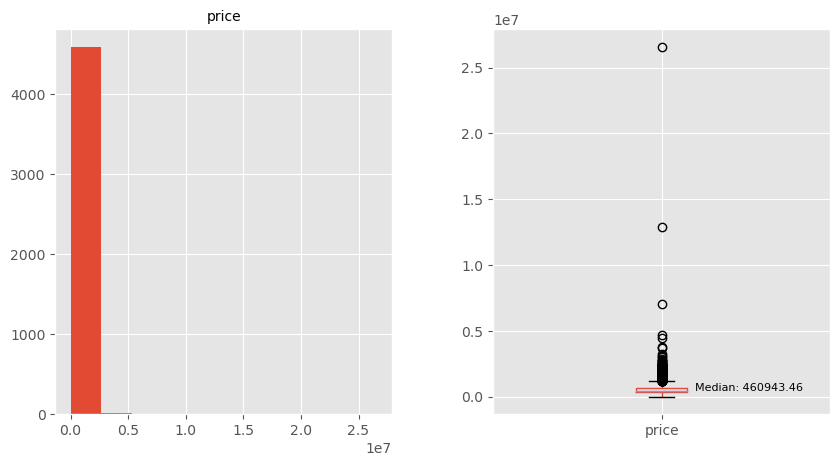

Price (min): 0.0
Price (max): 26590000.0


In [24]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

housedata.hist(ax=ax1, column="price")
housedata.boxplot(ax=ax2, column="price")
med = housedata.price.median()
ax2.text(x=1.1, y=med, s=f"Median: {med:.2f}", fontsize=8)
plt.show()

print("Price (min):", housedata.price.min())
print("Price (max):", housedata.price.max())

Vemos que tenemos valores anómalos y estos nos hacen difícl ver cómo se distribuyen.

- Por una parte hay viviendas con precio cero, lo cuál es un error
- Por otra parte hay algunas viviendas con un valor muy por encima del resto.

Vamos a analizar cada uno de los casos y veremos cómo proceder

#### Viviendas con valor `0`

In [25]:
pzero = len(housedata[housedata.price == 0])
total = len(housedata)

print("Los registros con price == 0 representan un"
      f" {pzero / total * 100:.2f}% del total"
      f"({pzero} de {total})")

Los registros con price == 0 representan un 1.07% del total(49 de 4600)


<div class="alert alert-block alert-warning"> 
    Debido al pequeño porcentaje de dasos decidimos eliminar los registros donde <code>price == 0</code> del DataFrame. 
</div>

#### Casos en los que precio es demasiado grande

Vamos a contar los outliers usando la fórmula 
$$
price > Q3 + (1,5 * IQR)
$$

Dónde:
- `Q3` es el tercer cuartil de `price`
- `IQR` es el *intervalo intercuartílco*

In [26]:
def get_outliers(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    x_max = (q3 + (1.5 * iqr))
    
    return x[x > x_max]

In [27]:
prices = housedata.loc[:, "price"]

outliers = get_outliers(prices)
price_max = min(outliers)
n_outliers = len(outliers)

print(f"{n_outliers} valores anómalos que representan un {n_outliers / len(prices) * 100:.2f}% del total.")

240 valores anómalos que representan un 5.22% del total.


In [28]:
## Teníamos outliers en la variable sqft_lot, ¿qué ocurre si los eliminamos?

# Vamos a ver con cuantos outliers nos quedamos si eliminamos los que tiene sqft_lot
sqft_lot = housedata.loc[:,"sqft_lot"]
sqft_lot_out = get_outliers(sqft_lot)
n_sqft_lot_out = len(sqft_lot_out)
print(f"sqft_lot: {n_sqft_lot_out} out of {len(sqft_lot)} ({n_sqft_lot_out / len(sqft_lot)* 100:.2f} %)")
sqft_lot_max = min(sqft_lot_out)

prices2 = housedata.loc[housedata.sqft_lot < sqft_lot_max, "price"]

outliers2 = get_outliers(prices2)
n_outliers2 = len(outliers2)

print(f"Aún hay {n_outliers2} valores anómalos que representan un {n_outliers2 / len(prices) * 100:.2f}% del total.")

sqft_lot: 541 out of 4600 (11.76 %)
Aún hay 208 valores anómalos que representan un 4.52% del total.


In [29]:
# ¿Hay intersección entre los outliers de price y sqft_lot?
out_intersect = (
    housedata
    .loc[(housedata.price >= price_max) & (housedata.sqft_lot >= sqft_lot_max)]
)
n_out_intersect = len(out_intersect)

print("La intersección entre los dos conjuntos de outliers"
      f"es de {n_out_intersect} ({n_out_intersect / len(housedata) * 100:.2f}%)")

La intersección entre los dos conjuntos de outlierses de 48 (1.04%)


<div class="alert alert-block alert-info">
<p>
<b><a id="price_outliers">[2]</a></b> Los valóres excesivamente grandes pueden distorsionar la predicción. No obstante el porcentaje es significativo. El porcentaje es significativo, y teniendo en cuenta que ya vamos a eliminar otros registros. Lo recomendable es dejarlos.
</p>
<p>
Adicionalmente se puede plantear una hipótesis de entrenamiento en la cuál sustituyamos los vlores anómalos por un precio aproximado al precio máximo.
</p>
</div>

<div class="alert alert-block alert-warning">
    Hay que tratar los outliers de <code>sqft_lot</code> por separado en el preprocesamiento. No podemos eliminarlos ya que representan un porcentaje significativo del dataset.
</div>

Como en ambos casos los *outliers* están por encima del límite superior, vamos a sustituirlos por el *quantil 90%* tal como se describe en [este artículo](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

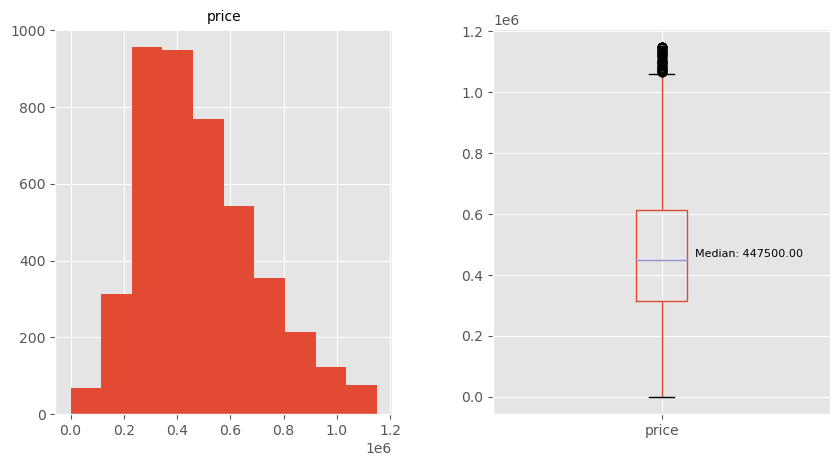

Price (min): 0.0
Price (max): 1150000.0


In [30]:
# Distribución de precio sin valores anómalos
aux = housedata[housedata.price < price_max]

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

aux.hist(ax=ax1, column="price")
aux.boxplot(ax=ax2, column="price")
med_price = aux.price.median()
ax2.text(x=1.1, y=med, s=f"Median: {med_price:.2f}", fontsize=8)
plt.show()

print("Price (min):", aux.price.min())
print("Price (max):", aux.price.max())

## Pre-procesado

In [31]:
housedata_clean = housedata.copy()

### Eliminar `price == 0`

In [32]:
# Eliminar los casos en los que price == 0
housedata_clean = housedata_clean[housedata_clean.price > 0]

### Sintetizar `yr_old` y eliminar `yr_built`

In [33]:
# Sintetizar la variable yr_old a partir de date - yr_built
housedata_clean["yr_old"] = housedata.apply(
    lambda x: x.date.year - x.yr_built,
    axis=1
)

# Eliminamos yr_built de las variables numéricas y la sustiuimos por yr_old
numeric_columns = [c for c in numeric_columns if c != "yr_built"] + ["yr_old"]

# El eliminado efectivo del dataframe lo hacemos en el último paso del pre-procesado

### Corregir `yr_renovated`

In [34]:
##  Procesar la variable yr_renovated

housedata_clean.yr_renovated = housedata_clean.apply(
    lambda x: x.yr_old if x.yr_renovated < x.yr_built else x.date.year - x.yr_renovated
    , axis=1
)

### Reemplazo de outliers en `sqft_lot`

/var/folders/jy/88_thsfj3xx4wvtlz4y08p6m7s11b_/T/ipykernel_82579/624048152.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(121)


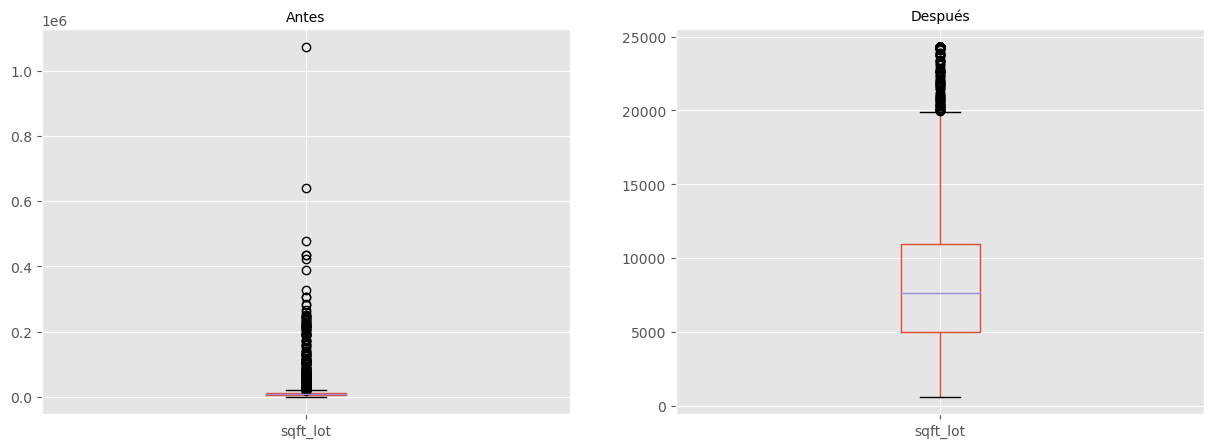

In [35]:
sqft_lot = housedata_clean.sqft_lot
sqft_lot_q90 = sqft_lot.quantile(.9)

housedata_clean.sqft_lot = np.where(sqft_lot > sqft_lot_q90, sqft_lot_q90, sqft_lot)

# Comparación antes y después
plt.figure(figsize=(15,5))
plt.title("Comparación antes vs después de eliminar outliers en sqft_lot")

ax1 = plt.subplot(121)
ax1.title.set_text("Antes")
housedata.boxplot(column="sqft_lot", ax=ax1)

ax2 = plt.subplot(122)
ax2.title.set_text("Después")
housedata_clean.boxplot(column="sqft_lot", ax=ax2)
plt.show()

### Eliminar columnas indeseadas

In [36]:
columns_to_drop = set(housedata_clean.columns) - set (numeric_columns + categorical_columns + [target])
print("Columnas para eliminar")
print(columns_to_drop)
print()

print("Dataset antes de eliminar:", housedata_clean.shape)
housedata_clean.drop(columns_to_drop, axis=1, inplace=True)
print("Dataset después de eliminar:", housedata_clean.shape)

Columnas para eliminar
{'date', 'sqft_living', 'yr_built', 'street', 'country'}

Dataset antes de eliminar: (4551, 19)
Dataset después de eliminar: (4551, 14)


In [37]:
# Comparación del resultado
before = len(housedata)
after = len(housedata_clean)
print(f"Antes de la limpieza: {before} viviendas")
print(f"Después de la limpieza: {after} viviendas ({after/before * 100:.2f}%)")
print()
print("Variable objetivo:", target)
print()
print("Columas numéricas:", numeric_columns)
print()
print("Columnas categóricas", categorical_columns)

Antes de la limpieza: 4600 viviendas
Después de la limpieza: 4551 viviendas (98.93%)

Variable objetivo: price

Columas numéricas: ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_renovated', 'yr_old']

Columnas categóricas ['city', 'statezip']


## Análisis de correlaciones

Vamos a realizar un análisis de correlaciones de todas las variables. Para ello vamos a usar un `LabelEncoder` para codificar todas las variables categóricas y así inlcuilas en el análisis.

In [38]:
# Codificar las variables categóricas
from sklearn.preprocessing import LabelEncoder

housedata_cat_enc = housedata_clean.copy()

for col in categorical_columns:
    print("Codificando variable:", col)
    le = LabelEncoder()
    housedata_cat_enc[col] = le.fit_transform(list(housedata_cat_enc[col].astype(str).values))
    
housedata_cat_enc.info()

Codificando variable: city
Codificando variable: statezip
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4551 entries, 0 to 4599
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4551 non-null   float64
 1   bedrooms       4551 non-null   float64
 2   bathrooms      4551 non-null   float64
 3   sqft_lot       4551 non-null   float64
 4   floors         4551 non-null   float64
 5   waterfront     4551 non-null   int64  
 6   view           4551 non-null   int64  
 7   condition      4551 non-null   int64  
 8   sqft_above     4551 non-null   int64  
 9   sqft_basement  4551 non-null   int64  
 10  yr_renovated   4551 non-null   int64  
 11  city           4551 non-null   int64  
 12  statezip       4551 non-null   int64  
 13  yr_old         4551 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 533.3 KB


In [39]:
# Calcular correlaciones

features = numeric_columns + categorical_columns
housedata_corr = housedata_cat_enc[features].corr()


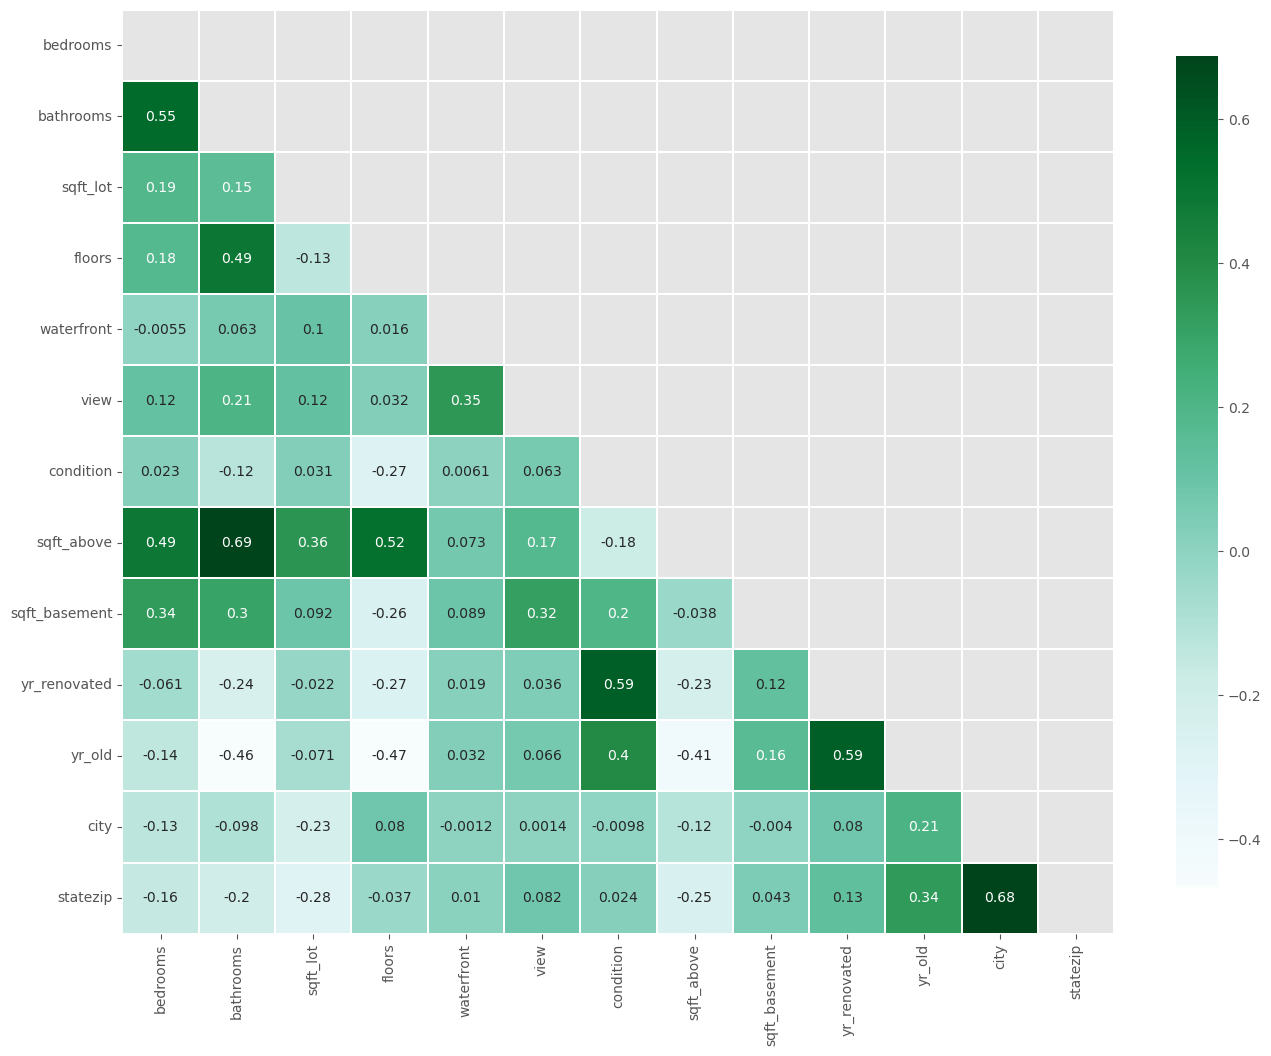

In [40]:
f, ax = plt.subplots(figsize=(16, 12))


mask = np.zeros_like(housedata_corr, dtype=bool) 
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    housedata_corr,
    linewidths=0.25,
    cmap="BuGn",
    linecolor='w',
    annot=True,
    annot_kws={"size":10},
    mask=mask,
    cbar_kws={"shrink": .9},
)
plt.show()

Vemos que hay algunas variables con correlaciones algo altas

In [41]:
def show_correlations(th):
    correlations=dict()
    for i,name in enumerate(housedata_corr.index):
        cols = list(housedata_corr.columns[i+1:])
        for col in cols:
            correlations[(name, col)] = housedata_corr.loc[name,col]

    return pd.DataFrame(
        data=[(i,c,v) for ((i,c),v) in correlations.items() if np.abs(v) > th],
        columns=["feat1", "feat2", "r"]).sort_values("r", ascending=False).set_index("feat1", drop=True)

show_correlations(0.5)

,feat2,r
feat1,,
bathrooms,sqft_above,0.687208
city,statezip,0.683687
condition,yr_renovated,0.590633
yr_renovated,yr_old,0.588599
bedrooms,bathrooms,0.547612
floors,sqft_above,0.522215


<div class="alert alert-block alert-info">
<p>
<b><a id="correlations">[3]</a></b> La existencia de variables correlacionadas puede indicar que estas son redundantes. La existencia de variables redundantes puede afectar al rendimiento del modelo. Pero no siempre. Correlación no implica dependencia lineal.
</p>
<p>
Esto plantea la posibilidad de eliminar algunas variables correlacionadas entre sí. Viendo la tabla anterior podremos probar las siguientes opciones
    <ul>
        <li>
            A) no hacer nada
        </li>
        <li>
            B) eliminar <code>sqft_above, yr_old, bedrooms</code>
        </li>
    </ul>
</p>
</div>

## Formulación de hipótesis de entrenamiento

Según el análisis exploratorio en [[1]](#city_and_statezip) parece ineresante interesante probar lo siguiente.

- Probar con todas las variables tanto numéricas como categoricas
- Excluir las variables `statezip` y `city`
- Excluir las variables `statezip` y dejar `city`
- Excluir las variables `city` y dejar `statezip`

Además según [[2]](#price_outliers) merece la pena realizar un tratamiento de outliers para la variable objetivo

- Probar dejando intacta `price`
- Probar a tratar los outliers de la variable `price`

Y según hemos visto en [[3]](#correlations) hay 4 alternativas más a la hora de eliminar variables correlacionadas.

Esto nos da una combinación de `4 x 2 x 2 = 16` hipótesis para probar. Además por cada una de las hipótesis vamos a probar distintos tipos de *scaler* y nos quedaremos con el que ofrezca mejor precisión (tomando como métrica el MSE). Esto último lo haremos ierando en la fase de entrenamiento.

En vez de generar los escenarios de entrenamiento a mano, vamos a automatizar la generación de hipótesis.


In [42]:
# Hipótesis basadas en los primerso 4 supuesos
def create_initial_hypotesis(df):
    # Diccionario
    # Nombre de la hipótesis, columnas a eliminar
    hypotesis = {
        "keep_all_columns": [],
        "-statezip -city": ["statezip", "city"],
        "-statezip": ["city"],
        "-city": ["city"],
    }
    
    for name, cols in hypotesis.items():
        yield name, df.drop(cols, axis=1)

In [43]:
# Hipótesis basadas en el reemplazo de outliers

def replace_price_outliers(df):
    aux = df.copy()
    price_q90 = df.price.quantile(.9)
    aux.price = np.where(df.price >= price_max, price_q90, df.price)
    return aux
    
def create_price_outliers_hypotesis(df):
    # Diccionario
    # Nombre de la hipótesis, función de tratamiento
    hypotesis = {
        "price_untouched": None,
        "price_outliers_replaced": replace_price_outliers
    }
    for name, fn in hypotesis.items():
        if fn is None:
            yield name, df
        else:
            yield name, fn(df)

In [44]:
# Hipótesis basadas en la eliminación de correlaciones

def create_correlation_hypotesis(df):
    # Diccionario
    # Nombre de la hipótesis, columnas a eliminar
    hypotesis = {
        "keep_all_columns": [],
        "-sqft_above -yr_old -bedrooms": ["sqft_above", "yr_old", "bedrooms"],
    }
    
    for name, cols in hypotesis.items():
        yield name, df.drop(cols, axis=1)

In [45]:
# Generamos las distintas hipótesis
def generate_hipotesis(df):
    hypotesis = list()
    for name1, df1 in create_initial_hypotesis(df):
        for name2, df2 in create_price_outliers_hypotesis(df1):
            for name3, df3 in create_correlation_hypotesis(df2):
                hn = name1 + " : " + name2 + " : " + name3
                hypotesis.append((hn, df3))
    return hypotesis

hypotesis = generate_hipotesis(housedata_clean)
print(f"Generadas {len(hypotesis)} hipótesis.")

Generadas 16 hipótesis.


In [46]:
# Mostramos un resumen de las hipótesis planteadas

hypotesis_summary = pd.DataFrame(
    columns=["Hypotesis name", "Number of columns"],
    data=[(name, len(df.columns)) for (name, df) in hypotesis]
)
pd.set_option('display.max_colwidth', None)
hypotesis_summary

,Hypotesis name,Number of columns
0,keep_all_columns : price_untouched : keep_all_columns,14
1,keep_all_columns : price_untouched : -sqft_above -yr_old -bedrooms,11
2,keep_all_columns : price_outliers_replaced : keep_all_columns,14
3,keep_all_columns : price_outliers_replaced : -sqft_above -yr_old -bedrooms,11
4,-statezip -city : price_untouched : keep_all_columns,12
5,-statezip -city : price_untouched : -sqft_above -yr_old -bedrooms,9
6,-statezip -city : price_outliers_replaced : keep_all_columns,12
7,-statezip -city : price_outliers_replaced : -sqft_above -yr_old -bedrooms,9
8,-statezip : price_untouched : keep_all_columns,13
9,-statezip : price_untouched : -sqft_above -yr_old -bedrooms,10


In [47]:
del hypotesis # Eliminamos la variable aparano consumir tanta memoria

## Entrenamiento

In [48]:
# Preparamos una función que codificará mediante un LabelEncoder
#  las variables categóricas que pueda tener un dataframe

def encode_categorical_vars(X):
    X_out = X.copy()
    encoders = dict()
    
    for col in X_out.columns:
        if col not in categorical_columns:
            continue
        le = LabelEncoder()
        print("Encoding:", col)
        X_out[col] = le.fit_transform(list(X_out[col].astype(str).values))
        encoders[col] = le
        
    
    return X_out, encoders

In [49]:
# Mediante esta función usamos diferentes scaler para escalar los datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

all_scalers = [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]
# all_scalers = [None]

def scale_dataframe(X_train, X_test, y_train, y_test):
    
    for Sc in all_scalers:
        scalers = dict()
        X_train_out = X_train.copy()
        X_test_out = X_test.copy()
        y_train_out = y_train.copy()
        y_test_out = y_test.copy()
        
        if Sc is not None:
            # Usamos un scaler para la variable objetivo
            scaler_y = Sc()
            scalers[target] = scaler_y
            y_train_out = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(1, -1)[0]
            y_test_out = scaler_y.transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

            # Usamos otro scaler ditinto para las variables de superficie
            sqft_cols = [c for c in X_train_out.columns if c.startswith("sqft")]
            scaler_sqft = Sc()
            scalers["sqft"] = scaler_sqft
            X_train_out.loc[:, sqft_cols] = scaler_sqft.fit_transform(X_train_out.loc[:, sqft_cols])
            X_test_out.loc[:, sqft_cols] = scaler_sqft.transform(X_test_out.loc[:, sqft_cols])
        
    
        yield X_train_out, X_test_out, y_train_out, y_test_out, scalers

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#
# Preparamos dos clases una representará un 'Entrenamiento' y la otra una 'Hipótesis'
# En cada una de las hipótesis realizaremos un entrenamiento distinto, para probar 
# distintos 'scalers'
#

class Training:
    def __init__(self, encoders, scalers):
        self.encoders = encoders     # Label encoders usados para las variables categóricas
        self.scalers = scalers       # Scalers usados par normalizar los datos
        self.model = None            # El modelo de regresión lineal entrenado
        self.fitted_values = None    # Predicciones del modelo sobre los datos de entrenamiento
        self.test_predictions = None # Predicciones del modelo sobre los datos de test
        self.mse_train = None        # Error cuadrático medio sobre los datos de entrenamienti
        self.mse_test = None         # Error cuadrático medio sobre los datos de test
        self.num_features = None     # Número de variables usadas para el entrenamiento
        self.score_train = None      # Precisión del modelo
        self.score_test = None      # Precisión del modelo
        
    def train_model(self, X_train, X_test, y_train, y_test):
#         print(f"\tTraining set. X: {X_train.shape}, y: {y_train.shape}")
#         print(f"\tTest set. X: {X_test.shape}, y: {y_test.shape}")
        
        self.num_features = X_train.shape[1]
        
        # Entrenamos el modelo
        self.model = LinearRegression()
        self.model.fit(X_train, y_train)
        
        # Almacenamos resultados del entrenamiento
        self.fitted_values = self.model.predict(X_train)
        self.test_predictions = self.model.predict(X_test)
        
        self.score_train = self.model.score(X_train, y_train)
        self.score_test = self.model.score(X_test, y_test)
        
        
        # Evaluamos el modelo
        self.mse_train = mean_squared_error(y_true=y_train, y_pred=self.fitted_values)
#         print("\tTRAIN MSE:", self.mse_train)
        self.mse_test = mean_squared_error(y_true=y_test, y_pred=self.test_predictions)
#         print("\tTEST_MSE:", self.mse_test)

class Hypotesis:
    def __init__(self):
        self.features = None               # Columnas usadas en el entrenamiento
        self.trainings: [Training] = None  # Distintos entrenamientos para la hipótesis
        self.best_model: Training = None   # Modelo con mayor precisión
            
    def train_models(self, df):
        self.features = list(df.columns)
        
        if self.trainings is None:
            self.trainings = []
        
        X = df.drop(target, axis=1)
        y = df[[target]]
        
        # Escalamos variables categóricas
        X, encoders = encode_categorical_vars(X)
        
        
        # Separamos el dataset en conjunto de entrenamiento y de test
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y.to_numpy(), 
            test_size=0.2, random_state=42
        )
#         print(f"\tTraining set. X: {X_train.shape}, y: {y_train.shape}")
#         print(f"\tTest set. X: {X_test.shape}, y: {y_test.shape}")
        
        # Bucle de entrenamiento
        for X_train, X_test, y_train, y_test, scalers in scale_dataframe(X_train, X_test, y_train, y_test):
            training = Training(encoders, scalers)
            training.train_model(X_train, X_test, y_train, y_test)
            self.trainings.append(training)
            
        # Seleccionar el mejor modelo
        min_mse = None
        for tr in self.trainings:
            tr_mse = max(tr.mse_train, tr.mse_test)
            if (self.best_model is None) or (tr_mse < min_mse):
                self.best_model = tr
                min_mse = tr_mse
                
        
        scdict = self.best_model.scalers
        scdesc = list(scdict.values()) if len(scdict) > 0 else []
        if len(scdesc) == 0:
            scdesc = "no-scaler"
        else:
            scdesc = scdesc[0]
        print("Features:", self.features)
        print("\tEl mejor modelo ha hecho uso de:", scdesc)
        print("\t\tTRAIN MSE:", self.best_model.mse_train)
        print("\t\tTEST_MSE:", self.best_model.mse_test)
        
        
        
# name, df = generate_hipotesis(housedata_clean)[0]

# hyp = Hypotesis()
# hyp.train_models(df)     

In [51]:
all_hypotesis = []  # Almacenaremos en esta lista las distintas hipótesis que hemos formulado
for i, dat in enumerate(generate_hipotesis(housedata_clean)):
    name, df = dat
    print(f"Hipótesis #{i:02d}: {df.shape} {name}")
    hyp = Hypotesis()
    hyp.train_models(df)
    all_hypotesis.append((name, hyp))
    print()

Hipótesis #00: (4551, 14) keep_all_columns : price_untouched : keep_all_columns
Encoding: city
Encoding: statezip
Features: ['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_renovated', 'city', 'statezip', 'yr_old']
	El mejor modelo ha hecho uso de: MaxAbsScaler()
		TRAIN MSE: 0.0004069260694938968
		TEST_MSE: 8.26695220169742e-05

Hipótesis #01: (4551, 11) keep_all_columns : price_untouched : -sqft_above -yr_old -bedrooms
Encoding: city
Encoding: statezip
Features: ['price', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_basement', 'yr_renovated', 'city', 'statezip']
	El mejor modelo ha hecho uso de: MaxAbsScaler()
		TRAIN MSE: 0.00043922277310068565
		TEST_MSE: 0.00010910836071422292

Hipótesis #02: (4551, 14) keep_all_columns : price_outliers_replaced : keep_all_columns
Encoding: city
Encoding: statezip
Features: ['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfro

## Evaluación

In [66]:
best_hypotesis = None

for name, hyp in all_hypotesis:
    if (best_hypotesis is None) or (hyp.best_model.mse_test < best_hypotesis[1].best_model.mse_test):
        best_hypotesis = (name, hyp)
        
name,  hyp = best_hypotesis
print("Mejor hipótesis")
print("MSE_TRAIN:", round(hyp.best_model.mse_train, 5))
print("MSE_TEST:", round(hyp.best_model.mse_test, 7))
print(name)

Mejor hipótesis
MSE_TRAIN: 0.00041
MSE_TEST: 8.27e-05
keep_all_columns : price_untouched : keep_all_columns


In [53]:
def scaler_name(scalers: dict) -> str:
    if len(scalers) == 0:
        return "no-scaler"
    else:
        return str(list(scalers.values())[0])

eval_data = [
    (
        name, 
        scaler_name(hyp.best_model.scalers), 
        hyp.best_model.mse_train, 
        hyp.best_model.mse_test,
        hyp.best_model.score_train,
        hyp.best_model.score_test,
    ) 
    for (name, hyp) in all_hypotesis
]

df_eval = (
    pd.DataFrame(eval_data, columns=["Name", "Scaler", "MSE_TRAIN", "MSE_TEST", "score_train", "score_test"])
).sort_values("MSE_TEST").reset_index(drop=True)

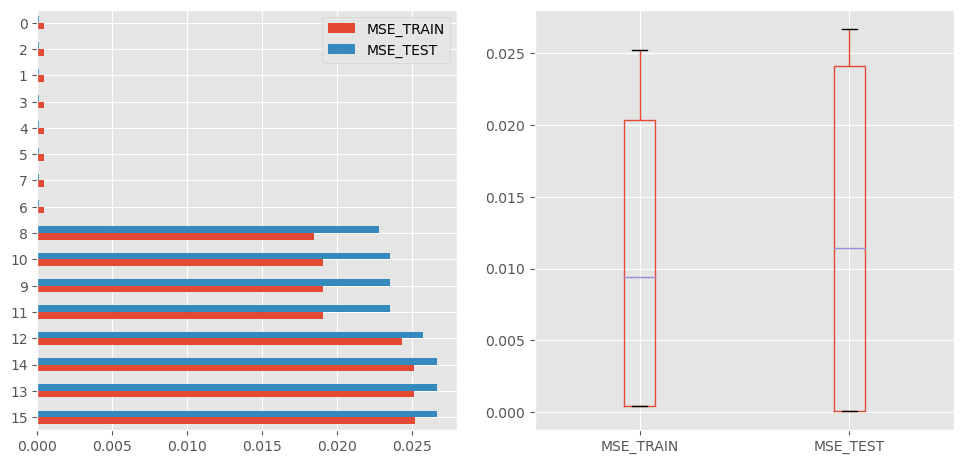

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df_eval[["MSE_TRAIN", "MSE_TEST"]].sort_values("MSE_TEST", ascending=False).plot(ax=axes[0], kind="barh")

df_eval.boxplot(column=["MSE_TRAIN","MSE_TEST"],ax=axes[1])

plt.tight_layout(pad=2.0)

In [55]:
df_eval

,Name,Scaler,MSE_TRAIN,MSE_TEST,score_train,score_test
0,keep_all_columns : price_untouched : keep_all_columns,MaxAbsScaler(),0.000407,0.000083,0.201447,0.607115
1,-statezip : price_untouched : keep_all_columns,MaxAbsScaler(),0.000408,0.000084,0.199880,0.601335
2,-city : price_untouched : keep_all_columns,MaxAbsScaler(),0.000408,0.000084,0.199880,0.601335
3,-statezip -city : price_untouched : keep_all_columns,MaxAbsScaler(),0.000408,0.000084,0.199761,0.600474
4,keep_all_columns : price_untouched : -sqft_above -yr_old -bedrooms,MaxAbsScaler(),0.000439,0.000109,0.138068,0.481465
5,-statezip -city : price_untouched : -sqft_above -yr_old -bedrooms,MaxAbsScaler(),0.000441,0.000111,0.135146,0.471335
6,-statezip : price_untouched : -sqft_above -yr_old -bedrooms,MaxAbsScaler(),0.000441,0.000111,0.135174,0.470961
7,-city : price_untouched : -sqft_above -yr_old -bedrooms,MaxAbsScaler(),0.000441,0.000111,0.135174,0.470961
8,keep_all_columns : price_outliers_replaced : keep_all_columns,MaxAbsScaler(),0.018439,0.022757,0.540118,0.417544
9,-statezip : price_outliers_replaced : keep_all_columns,MaxAbsScaler(),0.019028,0.023524,0.525428,0.397929


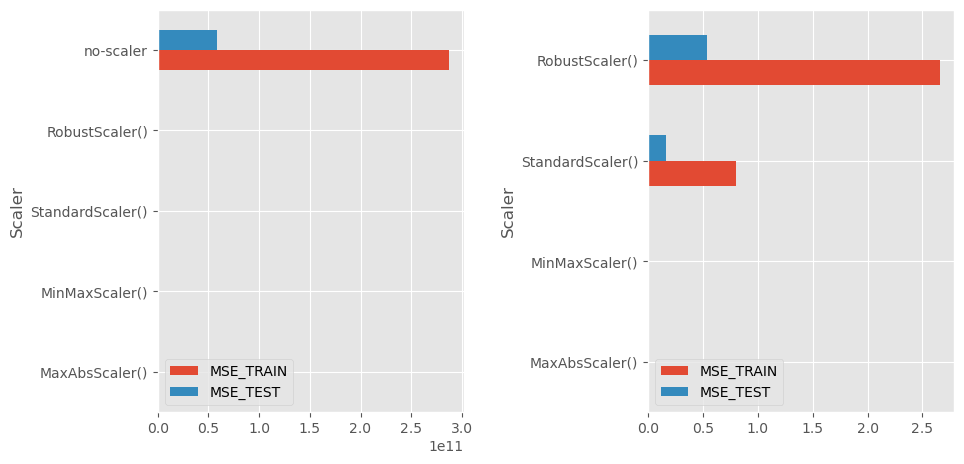

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

best = all_hypotesis[0][1]
df_sca_eval = pd.DataFrame(
    [(scaler_name(tr.scalers), tr.mse_train, tr.mse_test) for tr in best.trainings],
    columns=["Scaler", "MSE_TRAIN", "MSE_TEST"]
).set_index("Scaler", drop=True).sort_values("MSE_TEST", ascending=True)

df_sca_eval.plot(kind="barh", ax=axes[0])

df_sca_eval.drop("no-scaler").plot(kind="barh", ax=axes[1])

plt.tight_layout(pad=2.0)

In [57]:
best.trainings[0].score_test

0.6071148646655432

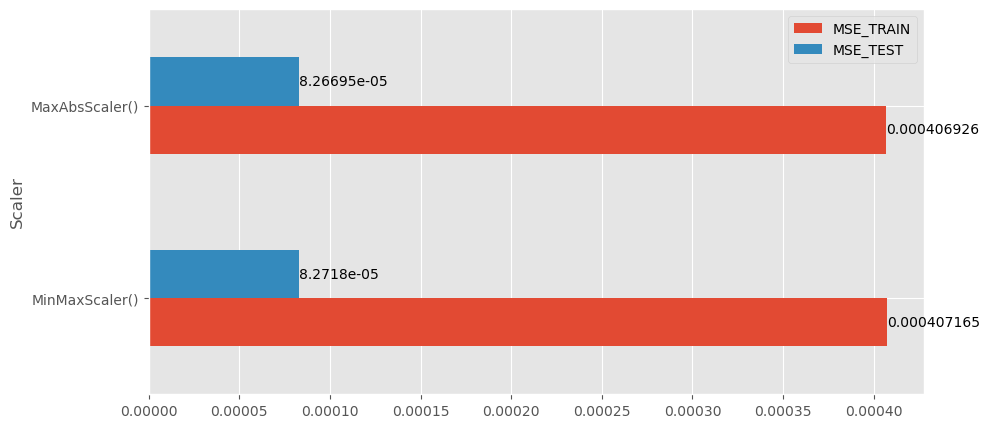

In [58]:
f, ax = plt.subplots(figsize=(10, 5))
df_sca_eval.loc[["MinMaxScaler()", "MaxAbsScaler()"]].plot(kind="barh", ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

## Conclusiones

In [59]:
for i, variant in enumerate(["StateAndCity", "PriceOutliers", "RemoveCorrelations"]):
    df_eval[variant] = df_eval.Name.apply(lambda x: x.split(":")[i])

    display(
        df_eval.groupby(variant).mean(numeric_only=True)[["MSE_TRAIN", "MSE_TEST", "score_train", "score_test"]].sort_values("MSE_TEST")
    )

,MSE_TRAIN,MSE_TEST,score_train,score_test
StateAndCity,,,,
keep_all_columns,0.010908,0.012162,0.318113,0.462104
-city,0.011258,0.012597,0.308284,0.446925
-statezip,0.011258,0.012597,0.308284,0.446925
-statezip -city,0.011271,0.012599,0.307915,0.446737


,MSE_TRAIN,MSE_TEST,score_train,score_test
PriceOutliers,,,,
price_untouched,0.000424,0.000097,0.168066,0.538123
price_outliers_replaced,0.021923,0.024880,0.453231,0.363222


,MSE_TRAIN,MSE_TEST,score_train,score_test
RemoveCorrelations,,,,
keep_all_columns,0.009644,0.011708,0.364666,0.502688
-sqft_above -yr_old -bedrooms,0.012702,0.013269,0.256632,0.398657
